![SURFnet logo](figs/surfnet_logo.png?raw=true) 

This document is a [Jupyter Notebook](http://jupyter.org/) containing the dynamic analysis of data provided on weekly basis by the the Dutch National Research and Education Network, SURFnet. This is an (ongoing) collaboration between the University of Twente and SURFnet. Since June 2015, SURFnet is using our Booters blacklist (constantly updated and openly shared at http://booterblacklist.com) to monitor the access to Booters. 

SURFnet monitors DNS queries using their EEMO plugin https://github.com/SURFnet/eemo. Before send any data to us they anonymize the information of their users using a code similar to the one available at https://github.com/jjsantanna/IP_anonymization_by_Roland. 

<h2>The content of this Notebook is the following:</h2>

<div id="TOC">
    <ul>
    <li><a href="#1">1. Preamble & Pre-analysis</a></li>
        <ul>
        <li><a href="#1.1">1.1. Which libraries we use to analyse the data?</a></li>
        <li><a href="#1.2">1.2. How SURFnet data looks like? [loding the raw data]</a></li>
        <li><a href="#1.3">1.3. What should be formated/fix/added to facilitate our analisis? </a></li>
        <li><a href="#1.4">1.4. What are the outliers that should be removed from the analysis? (in a first moment)</a></li>
        <li><a href="#1.5">1.5. How do we define the NEW data frame (excluding the outlier)</a></li>
        <li><a href="#1.6">1.6. How many different record types are there in the (remaining) data frame? and removing the outlier user?</a></li> 
        <li><a href="#1.7">1.7. What is the first, the last record, and the time window of the data?</a></li>
        </ul>
    <li><a href="#2">2. The analysis</a></li>
        <ul>
        <li><a href="#2.0.1">Defining 4-months periods</a></li>
        <li><a href="#2.1">2.1. Booters analysis</a></li>
            <ul>
            <li><a href="#2.1.1">2.1.1. How many distinct Booters were accessed by users in total? in Q1, Q2 and Q3?</a></li>
            <li><a href="#2.1.2">2.1.2. What is distribution of the number of access to Booters?</a></li>
            <li><a href="#2.1.3">2.1.3. What are the most accessed Booters? and for each 4-months period?</a></li>
            <li><a href="#2.1.4">2.1.4. What are the medians of access to the most accessed Booters?</a></li>
            </ul>
        <li><a href="#2.2.">2.2. Users Analysis</a></li>
            <ul>
            <li><a href="#2.2.1.">2.2.1. How many users are in the data?</a></li>
            <li><a href="#2.2.2.">2.2.2. What is the cumulative distribution of the requests per users?</a></li>
            <li><a href="#2.2.3.">2.2.3. Which are the top10 users?and how many times each top10 user request for a Booter?</a></li>
            <li><a href="#2.2.4.">2.2.4. How many accesses to Booters each top 10 user performed? How is the overall distribution of access to different Booters each user performed?</a></li>
            <li><a href="#2.2.5">2.2.5. What are the medians of access to the most accessed Booters?</a></li>
            </ul>
        </ul>
    <li><a href="#3">3.  What happened in the last week?</a></li>
    <li><a href="#4">WANT TO JOIN US?</a></li>
    </ul>
</div>

<div id="1"><h1><a href="#TOC">1. Preamble & Pre-analysis</a></h1></div>

<div id="1.1"><h2><a href="#TOC">1.1. Which libraries we use to analyse the data?</a></h2></div>

In [1]:
# CODE:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Styles: https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# print(plt.style.available)
# plt.xkcd()
# plt.style.use('ggplot')
# plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-muted')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.rcParams['axes.axisbelow']=True

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import datetime
from datetime import date, timedelta

from itertools import cycle, islice

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode()

print('pandas.__version__ is ', pd.__version__)
print('matplotlib.__version__ is ', matplotlib.__version__)

pandas.__version__ is  0.18.1
matplotlib.__version__ is  1.5.3


In [2]:
# CODE
lines = ['-', '--', ':', '-.']
mylines = list(islice(cycle(lines), None, 50))

markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
mymarkers = list(islice(cycle(markers), None, 50))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

mystyle=[]
for c in colors:
    for m in markers:
        for l in lines:
            mystyle.append(c+l+m)
            

# from random import shuffle
# shuffle(mystyle)

mystyle=list(islice(cycle(mystyle), None, 50))


#This is the color template that I use. For more information https://personal.sron.nl/~pault/colourschemes.pdf
mycolors4 = list(islice(cycle(['#4477AA','#117733','#DDCC77','#CC6677']), None, 4)) # we can change the '4' len(df that you want plot)
mycolors12 = list(islice(cycle(['#332288','#6699CC','#88CCEE','#44AA99','#117733','#999933','#DDCC77','#661100','#CC6677','#AA4466','#882255','#AA4499']), None, 12))

<div id="1.2"><h2><a href="#TOC">1.2. How the data looks like? [loding the raw data]</a></h2></div>

In [3]:
# CODE:
def strip_converter(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def convert_value(text):
    try:
        return text.strip().lower().replace('www.',"")
    except AttributeError:
        return text 

#VERY TIME CONSUMING BUT IMPORTANT    
def convert_totimestamp(timestamp):
    try:
        return pd.to_datetime(timestamp,unit='s')
    except AttributeError:
        return timestamp

# Loading the data. In pandas a dataset is loaded as "data frame" for this reason we use the acronym "df"
# We also skipp the lines that have more columns than expected ( we just need this 6 columns)
df0 = pd.read_csv('../../anon_booters.txt.gz', error_bad_lines=False, sep=',',\
                  names = ['timestamp', 'recordtype', 'user', 'in','querytype','value'],\
                  converters = {'timestamp': convert_totimestamp,
                                'recordtype' : strip_converter,
                                'user' : strip_converter,
                                'value': convert_value})
# Adding a column with 1's
df0['unit'] = 1 

# Overall information about the data 

In [4]:
total_records=len(df0)
print('total records: ',total_records)

total_users=len(df0[df0['recordtype']=='Q(Q)']['user'].value_counts())
print ('total users: ',total_users)

total_queries=len(df0[df0['recordtype']=='Q(Q)'])
print ('total queries: ',total_queries)

total_responses=len(df0[df0['recordtype']!='Q(Q)'])
print ('total responses: ',total_responses)

first_record=df0['timestamp'].head(1).values[0]
print ('first record: ',first_record)

last_record=df0['timestamp'].tail(1).values[0]
print ('last record: ', last_record)

day_span=(last_record-first_record).astype('timedelta64[D]')
print ('time span: ',day_span)

total records:  131468
total users:  601
total queries:  29913
total responses:  101555
first record:  2015-06-19T17:38:01.000000000
last record:  2017-03-19T22:03:19.000000000
time span:  639 days


<div id="1.4"><h2><a href="#TOC">1.4. What are the outliers that should be *removed from the analysis?</a></h2></div>

In [5]:
# CODE:
df0[df0['recordtype']=='Q(Q)']['user'].value_counts()[:10]

b8f093c23ba0c6f5df242e935218578262309846e7f45ad6fc8dc4c69eb23ee1    6329
a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e    1648
7b4f45b838b71c0b422ac872c22b31650d8a8765afcc003b8b3b6ca5b2cbed55    1388
561e20341386f1b637011983cd6b800e4e77496fd22c14843bfe8521706e68ad    1104
4fcc1341c071b5b7e0159696766868fbb63728e7db978c153ccc47df386410c1     962
18f9eec93778aa08e31a56b1f416f0d8704db9a56d36f3eebefeac80c7cb2cc5     880
6936a119cf12e9551e0f08ba9e71750108f4807cc522fbb23de6b6240e07eb38     810
8acd6af477c9b86d6ef54ee4dbf9a4910396bc7c9ad64d4c22b89e77626bf72a     661
0f972ef7b4abd26a505e0d0aa8d997f01a9ac75a5a4b0f8ec31852fd8979e74e     571
2fe0390dd55d56e6c2889f5ccd5361b233a78d7415ab4fd2a08a9fc0c0f42b80     461
Name: user, dtype: int64

- The first user identified by 'b8f093c23ba0c6f5df242e935218578262309846e7f45ad6fc8dc4c69eb23ee1' is clearly an outlier. By talking with our SURFnet they disclosured that such user is a TOR exit node. They also provide the identifier of a second exit node: '4fcc1341c071b5b7e0159696766868fbb63728e7db978c153ccc47df386410c1'. Although we analyse the behaviour of both users in the end of this notebook, we remove then from the main analysis of the dataset.

<div id="1.5"><h2><a href="#TOC">1.5. Defining the NEW data frame (excluding the TOR exit nodes, outlier)</a></h2></div>   

In [6]:
# CODE:
df = df0[(df0['user']!='b8f093c23ba0c6f5df242e935218578262309846e7f45ad6fc8dc4c69eb23ee1') & \
         (df0['user']!='4fcc1341c071b5b7e0159696766868fbb63728e7db978c153ccc47df386410c1')]

<div id="1.6"><h2><a href="#TOC">1.6. How many different record types are there in the (remaining) data frame? and removing the outlier user?</a></h2></div>

In [7]:
# PREPARING THE DATA
records_withoutliers= df0['recordtype'].value_counts()
records_withoutoutliers=df['recordtype'].value_counts()

merged = pd.concat([records_withoutliers,records_withoutoutliers], axis=1)
merged.columns = ['+ TOR nodes','- TOR nodes']

#Manually changed the order of query types
merged_sorted = merged.sort_values(['+ TOR nodes','- TOR nodes'], ascending=[False,True]).reindex(['Q(Q)', 'Q(R)', 'R(ANS)','R(ADD)','R(AUT)'])

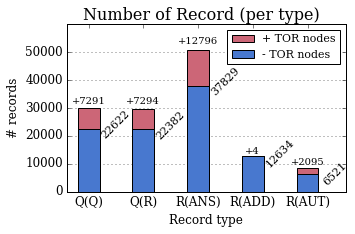

In [8]:
# VISUALIZING THE DATA
fig = plt.figure(figsize=(5, 3))

ax = plt.subplot2grid((1,1), (0,0))
rects1 = ax.bar(merged_sorted.reset_index().index+0.2, merged_sorted['+ TOR nodes'], width = .4, color='#CC6677')
rects2 = ax.bar(merged_sorted.reset_index().index+0.2, merged_sorted['- TOR nodes'], width = .4)
ax.set_ylim(0,59900)
ax.set_xlim(0,5.1)
ax.set_ylabel("# records")
ax.set_xlabel("Record type")

ax.legend((rects1[0], rects2[0]), merged_sorted.columns,prop={'size':11})

ax.set_xticks(merged_sorted.reset_index().index + 0.4)
ax.set_xticklabels(merged_sorted.index, rotation=0, ha='center')

def autolabel(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.+0.5, 1.03*height-5000, label, ha='center', va='bottom', rotation=45,size=11)       
autolabel(rects2,merged_sorted['- TOR nodes'])

def autolabel2(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, '+'+str(label), ha='center', va='bottom',size=10)
autolabel2(rects1,merged_sorted['+ TOR nodes']-merged_sorted['- TOR nodes'])


ax.yaxis.grid()
fig.suptitle('Number of Record (per type)', fontsize=16)

plt.show()
fig.suptitle('')
fig.savefig('figs/record_type.eps', bbox_inches='tight',format='eps', dpi=1200)

### Observation(s):
As expected, the number of queries including the outliers were bigger than without them. In each scenario (with and without outliers), Q(Q) = Q(R), and the number number of IPs associated to a DNS query is larger (i.e., R(ANS)>Q(R)).

<div id="2"><h1><a href="#TOC">2. The analysis</a></h1></div>

<div id="2.0.1"><h2><a href="#TOC">Defining 4-months periods</a></h2></div>

A quarter of a year is composed of three months, therefore the 4 quarters in the year are the following:
    - Q1: January, February and March
    - Q2: April, May and June
    - Q3: July, August and September 
    - Q4: October, November and December

As the data started being collected from 19 June 2015, we started analysing from q3/2015 (starting in July).

In [9]:
# CODE:
indexed_df = df.set_index(['timestamp']) #changing the index of the df

df_q3_2015 = indexed_df['2015-7-01':(datetime.date (2015, 10, 1) - datetime.timedelta (days = 1))]
df_q4_2015 = indexed_df['2015-10-01':(datetime.date (2016, 1, 1) - datetime.timedelta (days = 1))]
df_q1_2016 = indexed_df['2016-1-01':(datetime.date (2016, 4, 1) - datetime.timedelta (days = 1))]
df_q2_2016 = indexed_df['2016-4-01':(datetime.date (2016, 7, 1) - datetime.timedelta (days = 1))]
df_q3_2016 = indexed_df['2016-7-01':(datetime.date (2016, 10, 1) - datetime.timedelta (days = 1))]
df_q4_2016 = indexed_df['2016-10-01':(datetime.date (2017, 1, 1) - datetime.timedelta (days = 1))]
df_q1_2017 = indexed_df['2017-1-01':(datetime.date (2017, 4, 1) - datetime.timedelta (days = 1))]

# FOR THE FUTURE!!!
# df_q1_2017 = indexed_df['2017-1-01':'2017-3-31'] 
# df_q2_2017 = indexed_df['2017-4-01':'2017-6-31'] 
# df_q3_2017 = indexed_df['2017-7-01':'2017-9-31'] 
# df_q4_2017 = indexed_df['2017-10-01':'2017-12-31'] 


# Removing Outliers

In [10]:
df_q3_2016_without_outliers = df_q3_2016[df_q3_2016['user']!='a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e']
df_q4_2016_without_outliers = df_q4_2016[(df_q4_2016['user']!='a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496')&(df_q4_2016['user']!='096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6')]

## Outlier during Q3/2016

In [11]:
df_q3_2016[df_q3_2016['value']=='ddos.city.']['user'].value_counts().head(5)

a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e    2360
4377ec39b09b6ccaa43d2e3924cf38c17b67fa92f1215a3d38bf3dfd8e590dae      14
659acde1f8413054a86bfd274a0252072ff9e9ef088fb80ba62daa25047b7774       6
666ccb31666bd54d14ab078ab73d96cf04a01ec113a12dcd02e5a759019400ba       4
a13133036389ac9dd4762142ea36d3405bd78e12402f62df483d0f91fb427db6       4
Name: user, dtype: int64

We observed that user 'a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e'try to access 2360 times the Booter named 'ddos.city.' in July/2016 (Q3). Therefore we remove it from the analysis of this quarter! [the line bellow is shown for ilustration purpose]

In [12]:
df_q3_2016_without_outliers = df_q3_2016[df_q3_2016['user']!='a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e']

## Outilier during Q4/2016

In [13]:
df_q4_2016[df_q4_2016['recordtype']=='Q(Q)'].groupby('user').agg({'value': pd.Series.nunique}).sort_values(['value'], ascending=[False]).head(5)

,value
user,
a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496,178
096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6,90
7b4f45b838b71c0b422ac872c22b31650d8a8765afcc003b8b3b6ca5b2cbed55,21
f9a6b7ec0ccef96a70e8548e081fb92a4f281193c4a2eedf8bd554921783cc50,19
86c5fdd0cb089044d1ed52542eff433a26dd06255714815677cba18a4f4ada30,17


We observed that user 'a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496' and '096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6' try to resolve several subdomains of the 'ipstresser.com.' Booter. See bellow!

In [14]:
df_q4_2016[(df_q4_2016['user']=='a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496')& (df_q4_2016['recordtype']=='Q(Q)')]['value'].value_counts()

ipstresser.com.                 17
booter.xyz.                      3
mostwantedhf.info.               2
pda.ipstresser.com.              1
pc.ipstresser.com.               1
pc38.ipstresser.com.             1
pc10.ipstresser.com.             1
pc33.ipstresser.com.             1
post.ipstresser.com.             1
pix.ipstresser.com.              1
ppp6.ipstresser.com.             1
pc7.ipstresser.com.              1
postales.ipstresser.com.         1
page.ipstresser.com.             1
ppp17.ipstresser.com.            1
photos.ipstresser.com.           1
pc50.ipstresser.com.             1
owa1.ipstresser.com.             1
pc32.ipstresser.com.             1
quezstresser.com.                1
owa.ipstresser.com.              1
pop.ipstresser.com.              1
pc43.ipstresser.com.             1
im.ipstresser.com.               1
pc30.ipstresser.com.             1
ppp3.ipstresser.com.             1
pm.ipstresser.com.               1
pc17.ipstresser.com.             1
pe.ipstresser.com.  

In [15]:
df_q4_2016[(df_q4_2016['user']=='096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6')& (df_q4_2016['recordtype']=='Q(Q)')]['value'].value_counts()

ipstresser.com.                  15
booter.xyz.                       4
networkstresser.com.              4
mostwantedhf.info.                4
titaniumstresser.net.             2
mike.ipstresser.com.              2
spiderman.ipstresser.com.         1
software.ipstresser.com.          1
site.ipstresser.com.              1
avengestresser.com.               1
win2k3.ipstresser.com.            1
solutions.ipstresser.com.         1
members.ipstresser.com.           1
skywalker.ipstresser.com.         1
max.ipstresser.com.               1
slmail.ipstresser.com.            1
michigan.ipstresser.com.          1
windows.ipstresser.com.           1
legion.cm.                        1
southwest.ipstresser.com.         1
mgmt.ipstresser.com.              1
socal.ipstresser.com.             1
sms.ipstresser.com.               1
spokane.ipstresser.com.           1
silver.ipstresser.com.            1
merlin.ipstresser.com.            1
spock.ipstresser.com.             1
mci.ipstresser.com.         

The behavior of this 2 users(i.e., a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496 and 96a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6) is very used to try to discover the actual IP address of a domain name protected by DDoS protection companies (e.g., CloudFlare). We remove those 2 users from our analysis based on the following struction:

In [16]:
df_q4_2016_without_outliers = df_q4_2016[(df_q4_2016['user']!='a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496')&(df_q4_2016['user']!='096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6')]

<div id="2.1"><h1><a href="#TOC">2.1. Booters analysis</a></h1></div>

<div id="2.1.1"><h2><a href="#TOC">2.1.1. How many were the requests to Booters?</a></h2></div>


In [17]:
# PREPARING THE DATA
total_queries_q3_2015=len(df_q3_2015[df_q3_2015['recordtype']=='Q(Q)'])
total_queries_q4_2015=len(df_q4_2015[df_q4_2015['recordtype']=='Q(Q)'])
total_queries_q1_2016=len(df_q1_2016[df_q1_2016['recordtype']=='Q(Q)'])
total_queries_q2_2016=len(df_q2_2016[df_q2_2016['recordtype']=='Q(Q)'])
total_queries_q3_2016=len(df_q3_2016[df_q3_2016['recordtype']=='Q(Q)'])
total_queries_q4_2016=len(df_q4_2016[df_q4_2016['recordtype']=='Q(Q)'])
total_queries_q1_2017=len(df_q1_2017[df_q1_2017['recordtype']=='Q(Q)'])

total_queries_q3_2016_without_outliers=len(df_q3_2016_without_outliers[df_q3_2016_without_outliers['recordtype']=='Q(Q)'])
total_queries_q4_2016_without_outliers=len(df_q4_2016_without_outliers[df_q4_2016_without_outliers['recordtype']=='Q(Q)'])

concating_total_without_outliers = pd.Series.from_array([total_queries_q3_2015,
                                  total_queries_q4_2015,
                                  total_queries_q1_2016,
                                  total_queries_q2_2016,
                                  total_queries_q3_2016_without_outliers,
                                  total_queries_q4_2016_without_outliers,
                                                        total_queries_q1_2017])

concating_total_without_outliers.columns = ['Q3/2015', 
            'Q4/2015', 
            'Q1/2016', 
            'Q2/2016', 
            'Q3/2016',
            'Q4/2016',
                                           'Q1/2017']

In [18]:
#FITING FUNCTION (simple 3 degree polynomial fit)
z = np.polyfit(concating_total_without_outliers.index, concating_total_without_outliers, 3)
f = np.poly1d(z)
x_new = np.linspace(concating_total_without_outliers.index[0], concating_total_without_outliers.index[-1], 50)
y_new = f(x_new)

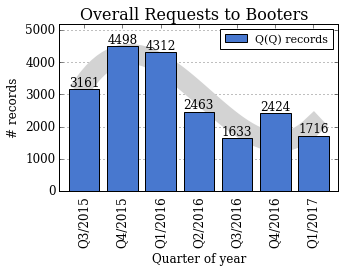

In [19]:
# Plotting
fig = plt.figure(figsize=(5, 3))

ax1 = plt.subplot2grid((1,1), (0,0))
ax1 = concating_total_without_outliers.plot.bar(ax=ax1,width = .8,zorder=10, label='Q(Q) records')
ax1.set_xticklabels(concating_total_without_outliers.columns)

ax1.set_ylabel("# records")
ax1.set_xlabel("Quarter of year")

#FITTING CURVE
ax1.plot(x_new,y_new,lw=20,color='lightgrey',zorder=1)

rects = ax1.patches
labels = concating_total_without_outliers
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax1.set_ylim(0,5200)

ax1.yaxis.grid()

fig.suptitle('Overall Requests to Booters', fontsize=16)
ax1.legend(prop={'size':11})

plt.show()
fig.suptitle('')
fig.savefig('figs/overall_req_per_quarter.eps', bbox_inches='tight',format='eps', dpi=1200)

# Compared to including the outliers

In [20]:
concating_total = pd.Series.from_array([total_queries_q3_2015,
                                  total_queries_q4_2015,
                                  total_queries_q1_2016,
                                  total_queries_q2_2016,
                                  total_queries_q3_2016,
                                  total_queries_q4_2016,
                                       total_queries_q1_2017])
concating_total.columns = ['Q3/2015', 
            'Q4/2015', 
            'Q1/2016', 
            'Q2/2016', 
            'Q3/2016*',
            'Q4/2016*',
            'Q1/2017']

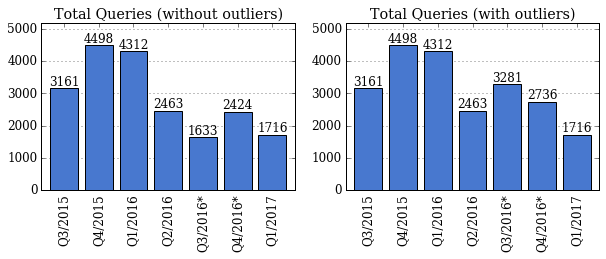

In [21]:
# Plotting
fig = plt.figure(figsize=(10, 3))

ax1 = plt.subplot2grid((1,2), (0,0))
ax1 = concating_total_without_outliers.plot.bar(ax=ax1,width = .8, title="Total Queries (without outliers)")
ax1.set_xticklabels(concating_total.columns)

rects = ax1.patches
labels = concating_total_without_outliers
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax1.set_ylim(0,5200)

ax1.yaxis.grid()

#####
ax2 = plt.subplot2grid((1,2), (0,1))
ax2 = concating_total.plot.bar(ax=ax2,width = .8, title="Total Queries (with outliers)")
ax2.set_xticklabels(concating_total.columns)

rects = ax2.patches
labels = concating_total
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
ax2.set_ylim(0,5200)

ax2.yaxis.grid()

fig.show()

<div id="2.1.1"><h2><a href="#TOC">2.1.1. How many distinct Booters were requested?</a></h2></div>

In [22]:
booters_q3_2015=len(df_q3_2015[df_q3_2015['recordtype']=='Q(Q)']['value'].value_counts())
booters_q4_2015=len(df_q4_2015[df_q4_2015['recordtype']=='Q(Q)']['value'].value_counts())
booters_q1_2016=len(df_q1_2016[df_q1_2016['recordtype']=='Q(Q)']['value'].value_counts())
booters_q2_2016=len(df_q2_2016[df_q2_2016['recordtype']=='Q(Q)']['value'].value_counts())
booters_q3_2016=len(df_q3_2016[df_q3_2016['recordtype']=='Q(Q)']['value'].value_counts())
booters_q3_2016_without_outliers=len(df_q3_2016_without_outliers[df_q3_2016_without_outliers['recordtype']=='Q(Q)']['value'].value_counts())
booters_q4_2016=len(df_q4_2016[df_q4_2016['recordtype']=='Q(Q)']['value'].value_counts())
booters_q4_2016_without_outliers=len(df_q4_2016_without_outliers[df_q4_2016_without_outliers['recordtype']=='Q(Q)']['value'].value_counts())
booters_q1_2017=len(df_q1_2017[df_q1_2017['recordtype']=='Q(Q)']['value'].value_counts())

concating_without_outliers = pd.Series.from_array([booters_q3_2015,
                                  booters_q4_2015,
                                  booters_q1_2016,
                                  booters_q2_2016,
                                  booters_q3_2016_without_outliers,
                                  booters_q4_2016_without_outliers,
                                                  booters_q1_2017])

concating_without_outliers.columns = ['Q3/2015', 
            'Q4/2015', 
            'Q1/2016', 
            'Q2/2016', 
            'Q3/2016',
            'Q4/2016',
                                     'Q1/2017']

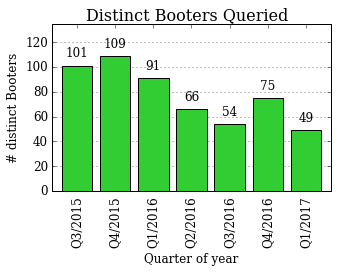

In [23]:
# Plotting
fig = plt.figure(figsize=(5, 3))
fig.subplots_adjust(hspace=0.5,wspace=0.2)

ax1 = plt.subplot2grid((1,1), (0,0))

ax1 = concating_without_outliers.plot.bar(ax=ax1,width = .8,color='limegreen')
ax1.set_xticklabels(concating_without_outliers.columns)
ax1.set_ylabel("# distinct Booters")
ax1.set_xlabel("Quarter of year")

rects = ax1.patches
labels = concating_without_outliers
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax1.set_ylim(0,135)

ax1.set_axisbelow(True)
ax1.yaxis.grid()

fig.suptitle('Distinct Booters Queried', fontsize=16)

plt.show()
# fig.suptitle('')
# fig.savefig('figs/queries_to_dist_booter.eps', bbox_inches='tight',format='eps', dpi=1200)

In [24]:
concating = pd.Series.from_array([booters_q3_2015,
                                  booters_q4_2015,
                                  booters_q1_2016,
                                  booters_q2_2016,
                                  booters_q3_2016,
                                  booters_q4_2016,
                                 booters_q1_2017])
concating.columns = ['Q3/2015', 
            'Q4/2015', 
            'Q1/2016', 
            'Q2/2016', 
            'Q3/2016*',
            'Q4/2016*',
                    'Q1/2017']

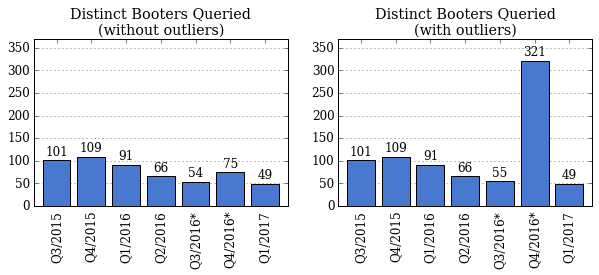

In [25]:
# Plotting
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(hspace=0.5,wspace=0.2)

ax1 = plt.subplot2grid((1,2), (0,0))

ax1 = concating_without_outliers.plot.bar(ax=ax1,width = .8, title="Distinct Booters Queried\n(without outliers)")
ax1.set_xticklabels(concating.columns)

rects = ax1.patches
labels = concating_without_outliers
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax1.set_ylim(0,370)

ax1.set_axisbelow(True)
ax1.yaxis.grid()

##
ax2 = plt.subplot2grid((1,2), (0,1))

ax2 = concating.plot.bar(ax=ax2,width = .8, title="Distinct Booters Queried\n(with outliers)")
ax2.set_xticklabels(concating.columns)

rects = ax2.patches
labels = concating
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

ax2.set_ylim(0,370)

ax2.set_axisbelow(True)
ax2.yaxis.grid()

fig.show()

<div id="2.1.2"><h2><a href="#TOC">2.1.2. What is distribution of the number of access to Booters?</a></h2></div>

In [26]:
serie_q3_2015 = df_q3_2015['value'][df_q3_2015['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q3_2015 = np.linspace(0.,1.,len(serie_q3_2015))
cdf_q3_2015 = pd.Series(cum_dist_q3_2015, index=serie_q3_2015)

serie_q4_2015 = df_q4_2015['value'][df_q4_2015['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q4_2015 = np.linspace(0.,1.,len(serie_q4_2015))
cdf_q4_2015 = pd.Series(cum_dist_q4_2015, index=serie_q4_2015)

serie_q1_2016 = df_q1_2016['value'][df_q1_2016['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q1_2016 = np.linspace(0.,1.,len(serie_q1_2016))
cdf_q1_2016 = pd.Series(cum_dist_q1_2016, index=serie_q1_2016)

serie_q2_2016 = df_q2_2016['value'][df_q2_2016['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q2_2016 = np.linspace(0.,1.,len(serie_q2_2016))
cdf_q2_2016 = pd.Series(cum_dist_q2_2016, index=serie_q2_2016)

serie_q3_2016_without_outliers = df_q3_2016_without_outliers['value'][df_q3_2016_without_outliers['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q3_2016_without_outliers = np.linspace(0.,1.,len(serie_q3_2016_without_outliers))
cdf_q3_2016_without_outliers = pd.Series(cum_dist_q3_2016_without_outliers, index=serie_q3_2016_without_outliers)

serie_q4_2016_without_outliers = df_q4_2016_without_outliers['value'][df_q4_2016_without_outliers['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q4_2016_without_outliers = np.linspace(0.,1.,len(serie_q4_2016_without_outliers))
cdf_q4_2016_without_outliers = pd.Series(cum_dist_q4_2016_without_outliers, index=serie_q4_2016_without_outliers)

serie_q1_2017 = df_q1_2017['value'][df_q1_2017['recordtype']=='Q(Q)'].value_counts().sort_values()
cum_dist_q1_2017 = np.linspace(0.,1.,len(serie_q1_2017))
cdf_q1_2017 = pd.Series(cum_dist_q1_2017, index=serie_q1_2017)

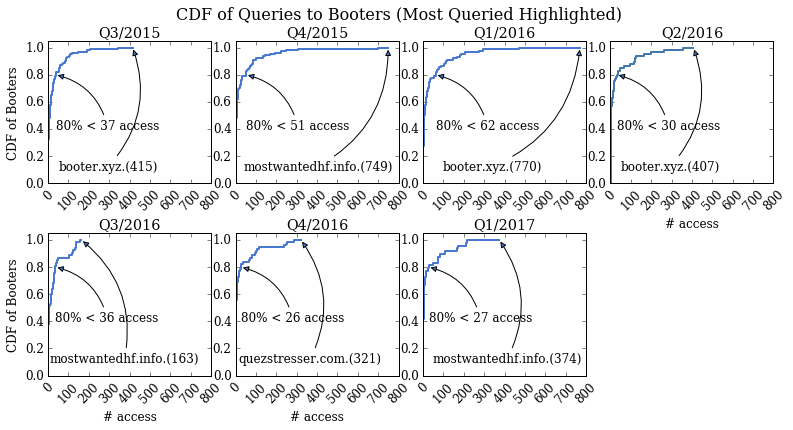

In [27]:
# Plot
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(hspace=0.35,wspace=0.15)

#####FOR Q3/2015
ax1 = plt.subplot2grid((2,4), (0,0))
ax1.set_ylim(0,1.05)
cdf_q3_2015.plot(lw=2, ax=ax1, drawstyle='steps', title="Q3/2015")
ax1.set_xlim(0,800)
ax1.set_xlabel("")
ax1.set_ylabel("CDF of Booters")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.annotate('80% < '+ str(cdf_q3_2015[cdf_q3_2015 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q3_2015[cdf_q3_2015 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q3_2015[cdf_q3_2015 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax1.annotate(serie_q3_2015.tail(1).index[0]+"("+
             str(serie_q3_2015.tail(1)[0])+")",
             (serie_q3_2015.tail(1)[0],1), xycoords='data',
             xytext=(serie_q3_2015.tail(1)[0]/8,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

#####FOR Q4/2015
ax2 = plt.subplot2grid((2,4), (0,1))
ax2.set_ylim(0,1.05)
cdf_q4_2015.plot(lw=2, ax=ax2, drawstyle='steps', title="Q4/2015")
ax2.set_xlim(0,800)
ax2.set_xlabel("")
# ax2.set_ylabel("CDF of Booters")
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax2.annotate('80% < '+ str(cdf_q4_2015[cdf_q4_2015 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q4_2015[cdf_q4_2015 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q4_2015[cdf_q4_2015 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>',
                            connectionstyle="arc3,rad=0.3"))

ax2.annotate(serie_q4_2015.tail(1).index[0]+"("+
             str(serie_q4_2015.tail(1)[0])+")",
             (serie_q4_2015.tail(1)[0],1), xycoords='data',
             xytext=(serie_q4_2015.tail(1)[0]/20,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

#####FOR Q1/2016
ax3 = plt.subplot2grid((2,4), (0,2))
ax3.set_ylim(0,1.05)
cdf_q1_2016.plot(lw=2, ax=ax3, drawstyle='steps', title="Q1/2016")
ax3.set_xlim(0,800)
ax3.set_xlabel("")
# ax3.set_ylabel("CDF of Booters")
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

ax3.annotate('80% < '+ str(cdf_q1_2016[cdf_q1_2016 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q1_2016[cdf_q1_2016 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q1_2016[cdf_q1_2016 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>',
                            connectionstyle="arc3,rad=0.3"))

ax3.annotate(serie_q1_2016.tail(1).index[0]+"("+
             str(serie_q1_2016.tail(1)[0])+")",
             (serie_q1_2016.tail(1)[0],1), xycoords='data',
             xytext=(serie_q1_2016.tail(1)[0]/8,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

#####FOR Q2/2016
ax4 = plt.subplot2grid((2,4), (0,3))
ax4.set_ylim(0,1.05)
cdf_q2_2016.plot(lw=2, ax=ax4, drawstyle='steps',color='#4477aa', title="Q2/2016")
ax4.set_xlim(0,800)
ax4.set_xlabel("# access")
# ax4.set_ylabel("CDF of Booters")
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

ax4.annotate('80% < '+ str(cdf_q2_2016[cdf_q2_2016 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q2_2016[cdf_q2_2016 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q2_2016[cdf_q2_2016 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>',
                            connectionstyle="arc3,rad=0.3"))

ax4.annotate(serie_q2_2016.tail(1).index[0]+"("+
             str(serie_q2_2016.tail(1)[0])+")",
             (serie_q2_2016.tail(1)[0],1), xycoords='data',
             xytext=(serie_q2_2016.tail(1)[0]/8,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

#####FOR Q3/2016
ax5 = plt.subplot2grid((2,4), (1,0))
ax5.set_ylim(0,1.05)
cdf_q3_2016_without_outliers.plot(lw=2, ax=ax5, drawstyle='steps', title="Q3/2016")
ax5.set_xlim(0,800)
ax5.set_xlabel("# access")
ax5.set_ylabel("CDF of Booters")
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)

ax5.annotate('80% < '+ str(cdf_q3_2016_without_outliers[cdf_q3_2016_without_outliers < 0.8].tail(1).index[0])+ ' access',
             (cdf_q3_2016_without_outliers[cdf_q3_2016_without_outliers < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q3_2016_without_outliers[cdf_q3_2016_without_outliers < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>',
                            connectionstyle="arc3,rad=0.3"))

ax5.annotate(serie_q3_2016_without_outliers.tail(1).index[0]+"("+
             str(serie_q3_2016_without_outliers.tail(1)[0])+")",
             (serie_q3_2016_without_outliers.tail(1)[0],1), xycoords='data',
             xytext=(serie_q3_2016_without_outliers.tail(1)[0]/20,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

#####FOR Q4/2016
ax6 = plt.subplot2grid((2,4), (1,1))

cdf_q4_2016_without_outliers.plot(lw=2, ax=ax6, drawstyle='steps',title="Q4/2016")
ax6.set_ylim(0,1.05)
ax6.set_xlim(0,800)
ax6.set_xlabel("# access")
# ax6.set_ylabel("CDF of Booters")
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

ax6.annotate('80% < '+ str(cdf_q4_2016_without_outliers[cdf_q4_2016_without_outliers < 0.8].tail(1).index[0])+ ' access',
             (cdf_q4_2016_without_outliers[cdf_q4_2016_without_outliers < 0.8].tail(1).index[0]
              ,0.8), xycoords='data',
             xytext=(cdf_q4_2016_without_outliers[cdf_q4_2016_without_outliers < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>',
                            connectionstyle="arc3,rad=0.3"))

ax6.annotate(serie_q4_2016_without_outliers.tail(1).index[0]+"("+
             str(serie_q4_2016_without_outliers.tail(1)[0])+")",
             (serie_q4_2016_without_outliers.tail(1)[0],1), xycoords='data',
             xytext=(serie_q4_2016_without_outliers.tail(1)[0]/20,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

#####FOR Q1/2017
ax7 = plt.subplot2grid((2,4), (1,2))
ax7.set_ylim(0,1.05)
cdf_q1_2017.plot(lw=2, ax=ax7, drawstyle='steps', title="Q1/2017")
ax7.set_xlim(0,800)
ax7.set_xlabel("")
# ax3.set_ylabel("CDF of Booters")
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)

ax7.annotate('80% < '+ str(cdf_q1_2017[cdf_q1_2017 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q1_2017[cdf_q1_2017 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q1_2017[cdf_q1_2017 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>',
                            connectionstyle="arc3,rad=0.3"))

ax7.annotate(serie_q1_2017.tail(1).index[0]+"("+
             str(serie_q1_2017.tail(1)[0])+")",
             (serie_q1_2017.tail(1)[0],1), xycoords='data',
             xytext=(serie_q1_2017.tail(1)[0]/8,0.1), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

fig.suptitle('CDF of Queries to Booters (Most Queried Highlighted)', fontsize=16)

plt.show()
# fig.suptitle('')
# fig.savefig('figs/cdf_booter_queries.eps', bbox_inches='tight',format='eps', dpi=1200)

# plotly.offline.iplot_mpl(fig)

In [28]:
df_q1_2016[(df_q1_2016['recordtype']=='Q(Q)')&(df_q1_2016['value']=='booter.xyz.')]['user'].value_counts()

18f9eec93778aa08e31a56b1f416f0d8704db9a56d36f3eebefeac80c7cb2cc5    201
7b4f45b838b71c0b422ac872c22b31650d8a8765afcc003b8b3b6ca5b2cbed55     50
062488d499397807f5b1f30f0c97a6162bf8e8aaedf51b34f33b6960f5e6fcea     42
4778e1a1a9a899ad68cbf91e7566860ac9c94cce707fc8127e6739841f03587e     37
6936a119cf12e9551e0f08ba9e71750108f4807cc522fbb23de6b6240e07eb38     30
3d871e5389b8434ca72af572b8885e3c9104897cb7ce0f5d5623e4c6bdcac15f     21
561e20341386f1b637011983cd6b800e4e77496fd22c14843bfe8521706e68ad     18
8acd6af477c9b86d6ef54ee4dbf9a4910396bc7c9ad64d4c22b89e77626bf72a     17
6a08a0ed68df7495e74392068398313951d40c84b7f000d5aeedc01d86d0e1f3     16
0686f9d08c1902d7e330250274f260ad817218d81bea35352d7ac46370c5cd7f     15
a13133036389ac9dd4762142ea36d3405bd78e12402f62df483d0f91fb427db6     14
4377ec39b09b6ccaa43d2e3924cf38c17b67fa92f1215a3d38bf3dfd8e590dae     14
63546d5b373aeee9ef6946e865f2d66f9ea4398606d0b141e5dc17bf683f1def     14
3c9d0942f598b82de921f8461977a66434e2712c547de01f3622bf6dbf57575b

<div id="2.1.3"><h2><a href="#TOC">2.1.3. What are the most accessed Booters? </a></h2></div>

In [29]:
top10booters_q3_2015_count = df_q3_2015['value'][df_q3_2015['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q3_2015=top10booters_q3_2015_count.index.tolist()

top10booters_q4_2015_count = df_q4_2015['value'][df_q4_2015['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q4_2015=top10booters_q4_2015_count.index.tolist()

top10booters_q1_2016_count = df_q1_2016['value'][df_q1_2016['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q1_2016=top10booters_q1_2016_count.index.tolist()

top10booters_q2_2016_count = df_q2_2016['value'][df_q2_2016['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q2_2016=top10booters_q2_2016_count.index.tolist()

top10booters_q3_2016_without_outliers_count = df_q3_2016_without_outliers['value'][df_q3_2016_without_outliers['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q3_2016_without_outliers=top10booters_q3_2016_without_outliers_count.index.tolist()

top10booters_q4_2016_without_outliers_count = df_q4_2016_without_outliers['value'][df_q4_2016_without_outliers['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q4_2016_without_outliers=top10booters_q4_2016_without_outliers_count.index.tolist()

top10booters_q1_2017_count = df_q1_2017['value'][df_q1_2017['recordtype']=='Q(Q)'].value_counts()[:10]
top10booters_q1_2017=top10booters_q1_2017_count.index.tolist()


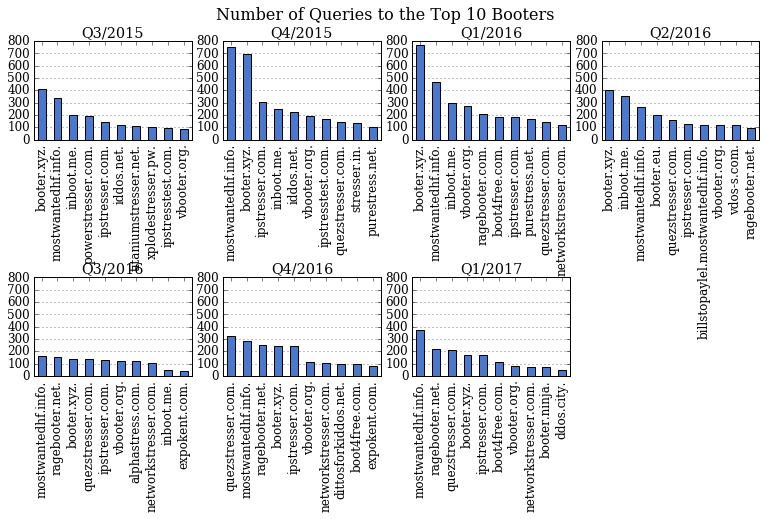

In [30]:
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(hspace=1.4,wspace=0.2)

ax1 = plt.subplot2grid((2,4), (0,0))
top10booters_q3_2015_count.plot.bar(ax=ax1, title="Q3/2015",ylim=(0,800))
ax1.yaxis.grid()

ax2 = plt.subplot2grid((2,4), (0,1))
top10booters_q4_2015_count.plot.bar(ax=ax2, title="Q4/2015",ylim=(0,800))
ax2.yaxis.grid()

ax3 = plt.subplot2grid((2,4), (0,2))
top10booters_q1_2016_count.plot.bar(ax=ax3, title="Q1/2016",ylim=(0,800))
ax3.yaxis.grid()

ax4 = plt.subplot2grid((2,4), (0,3))
top10booters_q2_2016_count.plot.bar(ax=ax4, title="Q2/2016",ylim=(0,800))
ax4.yaxis.grid()

ax5 = plt.subplot2grid((2,4), (1,0))
top10booters_q3_2016_without_outliers_count.plot.bar(ax=ax5, title="Q3/2016",ylim=(0,800))
ax5.yaxis.grid()

ax6 = plt.subplot2grid((2,4), (1,1))
top10booters_q4_2016_without_outliers_count.plot.bar(ax=ax6, title="Q4/2016",ylim=(0,800))
ax6.yaxis.grid()

ax7 = plt.subplot2grid((2,4), (1,2))
top10booters_q1_2017_count.plot.bar(ax=ax7, title="Q1/2017",ylim=(0,800))
ax7.yaxis.grid()

fig.suptitle('Number of Queries to the Top 10 Booters', fontsize=16)

plt.show()
# fig.suptitle('')
# fig.savefig('figs/top_booter_per_each_quarter.eps', bbox_inches='tight',format='eps', dpi=1200)

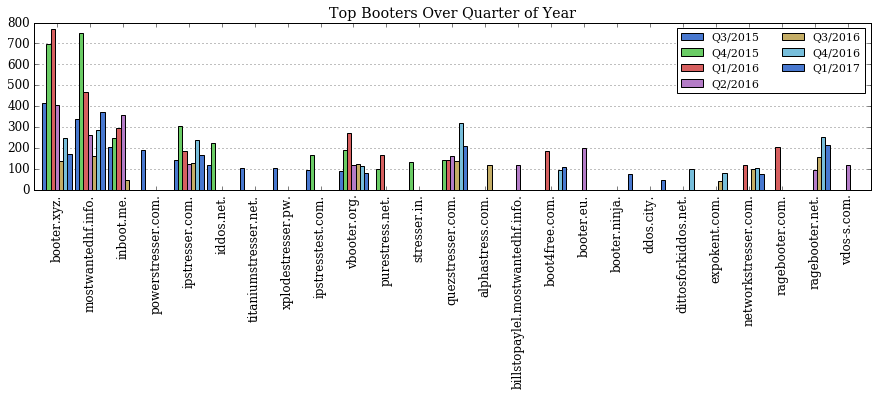

In [31]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=2,wspace=0.3)

ax = plt.subplot2grid((1,1), (0,0))
merged = pd.concat([top10booters_q3_2015_count,
                    top10booters_q4_2015_count,
                    top10booters_q1_2016_count,
                    top10booters_q2_2016_count,
                    top10booters_q3_2016_without_outliers_count,
                    top10booters_q4_2016_without_outliers_count,
                   top10booters_q1_2017_count,], axis=1)
merged.columns = ['Q3/2015', 'Q4/2015','Q1/2016','Q2/2016','Q3/2016','Q4/2016','Q1/2017']


merged.sort_values(['Q3/2015', 'Q4/2015'], ascending=[False,True]).plot.bar(ax=ax,width = .9)
ax.legend(numpoints=1, fontsize=11,loc=1, ncol=2)
ax.set_title('Top Booters Over Quarter of Year') 

ax.yaxis.grid()

plt.show()
# ax.set_title('') 
# fig.savefig('figs/top_booter_in_quarters.eps', bbox_inches='tight',format='eps', dpi=1200)

# Overtime Analysis

In [32]:
# CODE:
from matplotlib.dates import MONDAY,MonthLocator, WeekdayLocator, DateFormatter
q3_2015=pd.DataFrame(top10booters_q3_2015)
q4_2015=pd.DataFrame(top10booters_q4_2015)
q1_2016=pd.DataFrame(top10booters_q1_2016)
q2_2016=pd.DataFrame(top10booters_q2_2016)
q3_2016_without_outliers=pd.DataFrame(top10booters_q3_2016_without_outliers)
q4_2016_without_outliers=pd.DataFrame(top10booters_q4_2016_without_outliers)
q1_2017=pd.DataFrame(top10booters_q1_2017)

alltop10=list(pd.concat([q3_2015,
                         q4_2015,
                         q1_2016,
                         q2_2016,
                         q3_2016_without_outliers,
                         q4_2016_without_outliers,
                        q1_2017]).drop_duplicates().values.flatten())

df_without_outliers = df[(df['user']!='a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e') & \
         (df['user']!='a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496')]
#                          &\
#          (df['user']!='096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6')]

booters_permonth_without_outliers = pd.pivot_table(df_without_outliers[df_without_outliers['recordtype']=='Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='1M'), \
                    columns='value', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)  

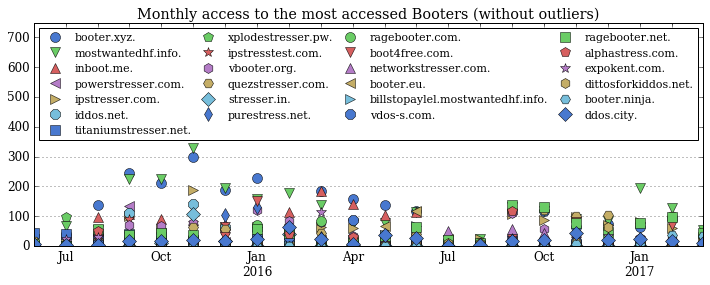

In [33]:
# CODE:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax1 = plt.subplot2grid((1,1), (0,0))

my_xticks = pd.date_range(start=booters_permonth_without_outliers[alltop10].index[0],
                       end=booters_permonth_without_outliers[alltop10].index[-1],
                       freq='M').to_pydatetime()

booters_permonth_without_outliers[alltop10].plot(ax=ax1,xticks=my_xticks,style=mymarkers,markersize=10,
                                                 title="Monthly access to the most accessed Booters (without outliers)")

ax1.legend(numpoints=1, fontsize=11,loc=1, ncol=4, mode="expand")

# http://stackoverflow.com/questions/26526230/plotting-datetimeindex-on-x-axis-with-matplotlib-creates-wrong-ticks-in-pandas-0
ax1.set_ylim(0,750)
ax1.set_xlabel("")
ax1.yaxis.grid()

plt.show()

# ax1.set_title('') 
# fig.savefig('figs/booter_access_overtime.eps', bbox_inches='tight',format='eps', dpi=1200)

# Comparing the overtime analysis with and without outliers

In [34]:
# General with outliers
booters_permonth = pd.pivot_table(df[df['recordtype']=='Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='1M'), \
                    columns='value', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

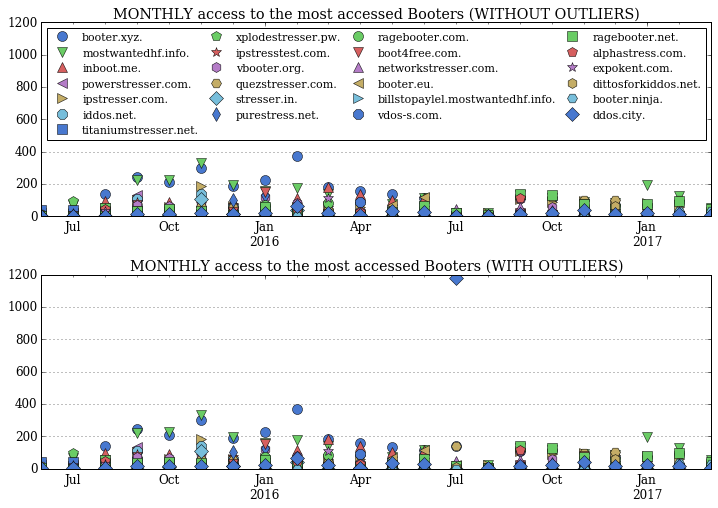

In [35]:
# CODE:
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3,wspace=0.3)

ax1 = plt.subplot2grid((2,1), (0,0))
booters_permonth_without_outliers[alltop10].plot(ax=ax1,style=mymarkers,markersize=10, title="MONTHLY access to the most accessed Booters (WITHOUT OUTLIERS)")
ax1.set_xlabel("")
ax1.yaxis.grid()
ax1.legend(numpoints=1, fontsize=11,loc=1, ncol=4, mode="expand")

# http://stackoverflow.com/questions/26526230/plotting-datetimeindex-on-x-axis-with-matplotlib-creates-wrong-ticks-in-pandas-0
ax1.set_ylim(0,1200)
ax2 = plt.subplot2grid((2,1), (1,0))
booters_permonth[alltop10].plot(ax=ax2,style=mymarkers,markersize=10, legend=False, title="MONTHLY access to the most accessed Booters (WITH OUTLIERS)")
ax2.set_xlabel("")


ax2.yaxis.grid()

<div id="2.2."><h1><a href="#TOC">2.2. Users Analysis</a></h1></div>

<div id="2.2.1."><h2><a href="#TOC">2.2.1. How many users are in the data?</a></h2></div>

In [49]:
# CODE:
users_q3_2015=df_q3_2015[df_q3_2015['recordtype']=='Q(Q)']['user'].value_counts().sort_values()
users_q4_2015=df_q4_2015[df_q4_2015['recordtype']=='Q(Q)']['user'].value_counts().sort_values()
users_q1_2016=df_q1_2016[df_q1_2016['recordtype']=='Q(Q)']['user'].value_counts().sort_values()
users_q2_2016=df_q2_2016[df_q2_2016['recordtype']=='Q(Q)']['user'].value_counts().sort_values()
users_q3_2016=df_q3_2016_without_outliers[df_q3_2016_without_outliers['recordtype']=='Q(Q)']['user'].value_counts().sort_values()
users_q4_2016=df_q4_2016_without_outliers[df_q4_2016_without_outliers['recordtype']=='Q(Q)']['user'].value_counts().sort_values()
users_q1_2017=df_q1_2017[df_q1_2017['recordtype']=='Q(Q)']['user'].value_counts().sort_values()

users_intersec_q3_q4_2015=len(users_q3_2015.index[users_q3_2015.index.isin(users_q4_2015.index)])
users_intersec_q4_q1_2016=len(users_q4_2015.index[users_q4_2015.index.isin(users_q1_2016.index)])
users_intersec_q1_q2_2016=len(users_q1_2016.index[users_q1_2016.index.isin(users_q2_2016.index)])
users_intersec_q2_q3_2016=len(users_q2_2016.index[users_q2_2016.index.isin(users_q3_2016.index)])
users_intersec_q3_q4_2016=len(users_q3_2016.index[users_q3_2016.index.isin(users_q4_2016.index)])
users_intersec_q4_q1_2017=len(users_q4_2016.index[users_q4_2016.index.isin(users_q1_2017.index)])


concating_total_users = pd.Series.from_array([len(users_q3_2015),
                                  len(users_q4_2015),
                                  len(users_q1_2016),
                                  len(users_q2_2016),
                                  len(users_q3_2016),
                                  len(users_q4_2016),
                                              len(users_q1_2017)])

concating_total_users.columns = ['Q3/2015', 
                                'Q4/2015', 
                                'Q1/2016', 
                                'Q2/2016', 
                                'Q3/2016',
                                'Q4/2016',
                                'Q1/2017']

concating_intersec_users = pd.Series.from_array([0,
                                              users_intersec_q3_q4_2015,
                                              users_intersec_q4_q1_2016,
                                              users_intersec_q1_q2_2016,
                                              users_intersec_q2_q3_2016,
                                              users_intersec_q3_q4_2016,
                                                users_intersec_q4_q1_2017])

merged = pd.concat([concating_total_users,concating_intersec_users], axis=1)

merged.columns = ['Actual','Same from the previous']
# merged_sorted = merged.sort_values(['With 2 TOR nodes','Without 2 TOR nodes'], ascending=[False,True])

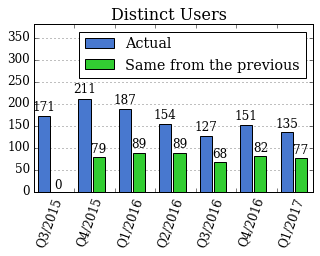

In [51]:
fig = plt.figure(figsize=(5, 3))

ax = plt.subplot2grid((1,1), (0,0))
rects1 = ax.bar(merged.index+0.1, merged['Actual'], 0.3)
rects2 = ax.bar(merged.index+0.45, merged['Same from the previous'], 0.3, color='limegreen')

ax.set_ylim(0,380)
ax.set_xlim(0,6.9)
ax.legend((rects1[0], rects2[0]), merged.columns)

def autolabel(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, label, ha='center', va='bottom')
        
autolabel(rects1,merged.Actual)
autolabel(rects2,merged['Same from the previous'])

ax.set_xticklabels(concating_total_users.columns)
ax.set_xticklabels(concating_total_users.columns, rotation=70, ha='left')

ax.yaxis.grid()

fig.suptitle('Distinct Users', fontsize=16)

plt.show()
# fig.suptitle('')
# fig.savefig('figs/overall_dist_users.eps', bbox_inches='tight',format='eps', dpi=1200)

# Distinct Users and Booters per quarter

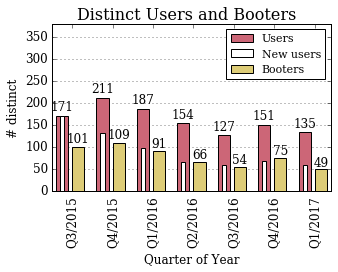

In [52]:
fig = plt.figure(figsize=(5, 3))

ax = plt.subplot2grid((1,1), (0,0))
rects1 = ax.bar(merged.index+0.1, merged['Actual'], 0.3,color='#CC6677')
rects2 = ax.bar(merged.index+0.2, merged['Actual']-merged['Same from the previous'], 0.1, color='w')

rects3 = ax.bar(concating_without_outliers.index+0.5, concating_without_outliers, width = .3,color='#DDCC77')

ax.set_ylabel("# distinct")
ax.set_xlabel("Quarter of Year")

ax.set_ylim(0,380)
ax.set_xlim(0,6.9)
ax.legend((rects1[0], rects2[0]), merged.columns)

def autolabel(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, label, ha='center', va='bottom')
        
autolabel(rects1,merged.Actual)
autolabel(rects3,concating_without_outliers)

ax.set_xticks(concating_without_outliers.index+0.5)
ax.set_xticklabels(concating_without_outliers.columns, rotation=90,ha='center')  


ax.legend((rects1[0], rects2[0], rects3[0]), ['Users','New users','Booters'],prop={'size':11})


ax.yaxis.grid()

fig.suptitle('Distinct Users and Booters', fontsize=16)

plt.show()
fig.suptitle('')

fig.savefig('figs/dist_users_and_booters.eps', bbox_inches='tight',format='eps', dpi=1200)

<div id="2.2.2."><h2><a href="#TOC">2.2.2. What is the cumulative distribution of the requests per users?</a></h2></div>

In [54]:
# CODE:
cum_dist_q3_2015 = np.linspace(0.,1.,len(users_q3_2015))
cdf_q3_2015 = pd.Series(cum_dist_q3_2015, index=users_q3_2015)

cum_dist_q4_2015 = np.linspace(0.,1.,len(users_q4_2015))
cdf_q4_2015 = pd.Series(cum_dist_q4_2015, index=users_q4_2015)

cum_dist_q1_2016 = np.linspace(0.,1.,len(users_q1_2016))
cdf_q1_2016 = pd.Series(cum_dist_q1_2016, index=users_q1_2016)

cum_dist_q2_2016 = np.linspace(0.,1.,len(users_q2_2016))
cdf_q2_2016 = pd.Series(cum_dist_q2_2016, index=users_q2_2016)

cum_dist_q3_2016 = np.linspace(0.,1.,len(users_q3_2016 ))
cdf_q3_2016 = pd.Series(cum_dist_q3_2016, index=users_q3_2016)

cum_dist_q4_2016 = np.linspace(0.,1.,len(users_q4_2016))
cdf_q4_2016 = pd.Series(cum_dist_q4_2016, index=users_q4_2016)

cum_dist_q1_2017 = np.linspace(0.,1.,len(users_q1_2017))
cdf_q1_2017 = pd.Series(cum_dist_q1_2017, index=users_q1_2017)

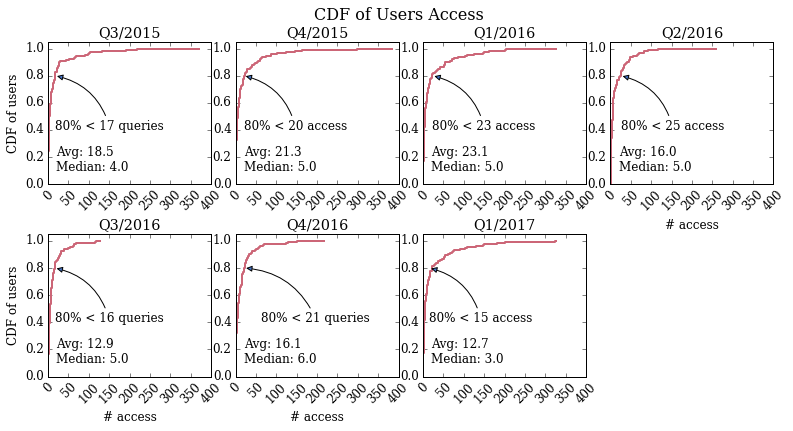

In [59]:
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(hspace=0.35,wspace=0.15)

ax1 = plt.subplot2grid((2,4), (0,0))
cdf_q3_2015.plot(lw=2, ax=ax1, drawstyle='steps', title="Q3/2015",color='#CC6677')
ax1.set_xlabel("")
ax1.set_ylabel("CDF of users")
ax1.set_ylim(0,1.05)
ax1.set_xlim(0,400)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.annotate('80% < '+ str(cdf_q3_2015[cdf_q3_2015 < 0.8].tail(1).index[0])+ ' queries',
             (cdf_q3_2015[cdf_q3_2015 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q3_2015[cdf_q3_2015 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax1.annotate('Avg: '+str(users_q3_2015.mean().round(decimals=1))+'\nMedian: '+ str(users_q3_2015.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')

####
ax2 = plt.subplot2grid((2,4), (0,1))
cdf_q4_2015.plot(lw=2, ax=ax2, drawstyle='steps', title="Q4/2015",color='#CC6677')
ax2.set_xlabel("")
# ax2.set_ylabel("CDF of users")
ax2.set_ylim(0,1.05)
ax2.set_xlim(0,400)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax2.annotate('80% < '+ str(cdf_q4_2015[cdf_q4_2015 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q4_2015[cdf_q4_2015 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q4_2015[cdf_q4_2015 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax2.annotate('Avg: '+str(users_q4_2015.mean().round(decimals=1))+'\nMedian: '+ str(users_q4_2015.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')


####
ax3 = plt.subplot2grid((2,4), (0,2))
cdf_q1_2016.plot(lw=2, ax=ax3, drawstyle='steps', title="Q1/2016",color='#CC6677')
ax3.set_xlabel("")
# ax3.set_ylabel("CDF of users")
ax3.set_ylim(0,1.05)
ax3.set_xlim(0,400)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

ax3.annotate('80% < '+ str(cdf_q1_2016[cdf_q1_2016 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q1_2016[cdf_q1_2016 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q1_2016[cdf_q1_2016 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax3.annotate('Avg: '+str(users_q1_2016.mean().round(decimals=1))+'\nMedian: '+ str(users_q1_2016.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')


####
ax4 = plt.subplot2grid((2,4), (0,3))
cdf_q2_2016.plot(lw=2, ax=ax4, drawstyle='steps', title="Q2/2016",color='#CC6677')
ax4.set_xlabel("# access")
# ax4.set_ylabel("CDF of users")
ax4.set_ylim(0,1.05)
ax4.set_xlim(0,400)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

ax4.annotate('80% < '+ str(cdf_q2_2016[cdf_q2_2016 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q2_2016[cdf_q2_2016 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q2_2016[cdf_q2_2016 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax4.annotate('Avg: '+str(users_q2_2016.mean().round(decimals=1))+'\nMedian: '+ str(users_q2_2016.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')

####
ax5 = plt.subplot2grid((2,4), (1,0))
cdf_q3_2016.plot(lw=2, ax=ax5, drawstyle='steps', title="Q3/2016",color='#CC6677')
ax5.set_xlabel("# access")
ax5.set_ylabel("CDF of users")
ax5.set_ylim(0,1.05)
ax5.set_xlim(0,400)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)

ax5.annotate('80% < '+ str(cdf_q3_2016[cdf_q3_2016 < 0.8].tail(1).index[0])+ ' queries',
             (cdf_q3_2016[cdf_q3_2016 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q3_2016[cdf_q3_2016 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax5.annotate('Avg: '+str(users_q3_2016.mean().round(decimals=1))+'\nMedian: '+ str(users_q3_2016.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')

####
ax6 = plt.subplot2grid((2,4), (1,1))
cdf_q4_2016.plot(lw=2, ax=ax6, drawstyle='steps', title="Q4/2016",color='#CC6677')
ax6.set_xlabel("# access")
# ax6.set_ylabel("CDF of users")
ax6.set_ylim(0,1.05)
ax6.set_xlim(0,400)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

ax6.annotate('80% < '+ str(cdf_q4_2016[cdf_q4_2016 < 0.8].tail(1).index[0])+ ' queries',
             (cdf_q4_2016[cdf_q4_2016 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q4_2016[cdf_q4_2016 < 0.8].tail(1).index[0]*3, 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax6.annotate('Avg: '+str(users_q4_2016.mean().round(decimals=1))+'\nMedian: '+ str(users_q4_2016.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')

####
ax7 = plt.subplot2grid((2,4), (1,2))
cdf_q1_2016.plot(lw=2, ax=ax7, drawstyle='steps', title="Q1/2017",color='#CC6677')
ax7.set_xlabel("")
# ax3.set_ylabel("CDF of users")
ax7.set_ylim(0,1.05)
ax7.set_xlim(0,400)
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)

ax7.annotate('80% < '+ str(cdf_q1_2017[cdf_q1_2017 < 0.8].tail(1).index[0])+ ' access',
             (cdf_q1_2017[cdf_q1_2017 < 0.8].tail(1).index[0],0.8), xycoords='data',
             xytext=(cdf_q1_2017[cdf_q1_2017 < 0.8].tail(1).index[0], 0.40), textcoords='data',
             arrowprops=dict(arrowstyle='-|>', connectionstyle="arc3,rad=0.3"))

ax7.annotate('Avg: '+str(users_q1_2017.mean().round(decimals=1))+'\nMedian: '+ str(users_q1_2017.median()),
             (0,0), xycoords='data',
             xytext=(20,0.1), textcoords='data')

fig.suptitle('CDF of Users Access', fontsize=16)

plt.show()
fig.suptitle('')

fig.savefig('figs/cdf_users_access.eps', bbox_inches='tight',format='eps', dpi=1200)


<div id="2.2.3."><h2><a href="#TOC">2.2.3. Which are the top10 users?and how many times each top10 user request for a Booter?</a></h2></div>

In [60]:
# CODE:

top10users_q3_2015_count = df_q3_2015['user'][df_q3_2015['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q3_2015=top10users_q3_2015_count.index.tolist()

top10users_q4_2015_count = df_q4_2015['user'][df_q4_2015['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q4_2015=top10users_q4_2015_count.index.tolist()

top10users_q1_2016_count = df_q1_2016['user'][df_q1_2016['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q1_2016=top10users_q1_2016_count.index.tolist()

top10users_q2_2016_count = df_q2_2016['user'][df_q2_2016['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q2_2016=top10users_q2_2016_count.index.tolist()

top10users_q3_2016_count = df_q3_2016['user'][df_q3_2016['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q3_2016=top10users_q3_2016_count.index.tolist()

top10users_q4_2016_count = df_q4_2016['user'][df_q4_2016['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q4_2016=top10users_q4_2016_count.index.tolist()

top10users_q3_2016_without_outliers_count = df_q3_2016_without_outliers['user'][df_q3_2016_without_outliers['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q3_2016_without_outliers=top10users_q3_2016_without_outliers_count.index.tolist()

top10users_q4_2016_without_outliers_count = df_q4_2016_without_outliers['user'][df_q4_2016_without_outliers['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q4_2016_without_outliers=top10users_q4_2016_without_outliers_count.index.tolist()

top10users_q1_2017_count = df_q1_2017['user'][df_q1_2017['recordtype']=='Q(Q)'] .value_counts()[:10]
top10users_q1_2017=top10users_q1_2017_count.index.tolist()


users_q3_2015=pd.DataFrame(top10users_q3_2015)
users_q4_2015=pd.DataFrame(top10users_q4_2015)
users_q1_2016=pd.DataFrame(top10users_q1_2016)
users_q2_2016=pd.DataFrame(top10users_q2_2016)
users_q3_2016=pd.DataFrame(top10users_q3_2016)
users_q4_2016=pd.DataFrame(top10users_q4_2016)
users_q1_2017=pd.DataFrame(top10users_q1_2017)


alltop10_users=list(pd.concat([users_q3_2015,
                         users_q4_2015,
                         users_q1_2016,
                         users_q2_2016,
                         users_q3_2016,
                         users_q4_2016,
                              users_q1_2017]).drop_duplicates().values.flatten())

users_permonth = pd.pivot_table(df[df['recordtype']=='Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='30D'), \
                    columns='user', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

outliers=['a3a7b240646f706162ecce4e4f762288f400905b872d362bcf7c32f336208e6e',
          'a9894d59bb912dbf45f381f2868877519b525be4a618a6855a46837b188be496',
          '096a60eccdacdca3cbfe427f18cbe77840fd117ca2579040974fe0b6e0c518d6']
alltop10_without_outliers=list(set(alltop10_users)-set(outliers))         

users_permonth_without_outliers =users_permonth.drop(outliers,1)

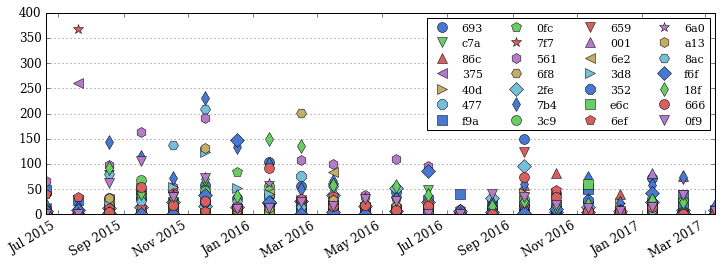

In [61]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax1 = plt.subplot2grid((1,1), (0,0), colspan=3)
users_permonth_without_outliers[alltop10_without_outliers].plot(ax=ax1,style=mymarkers,markersize=10, legend=False)
ax1.set_xlabel("")
# ax1.set_ylim(0,750)
ax1.set_xlabel("")
ax1.yaxis.grid()
ax1.legend(pd.DataFrame(alltop10_without_outliers)[0].str[:3],prop={'size':11},numpoints=1, ncol=4)



<div id="2.2.4."><h2><a href="#TOC">2.2.4. How many accesses to Booters each top 10 user performed? How is the overall distribution of access to different Booters each user performed?</a></h2></div>

In [62]:
users_permonth = pd.pivot_table(df[df['recordtype']=='Q(Q)'], 
                                  index='user', 
                                  columns='value', 
                                  values='unit', 
                                  aggfunc=np.sum, 
                                  fill_value=0)

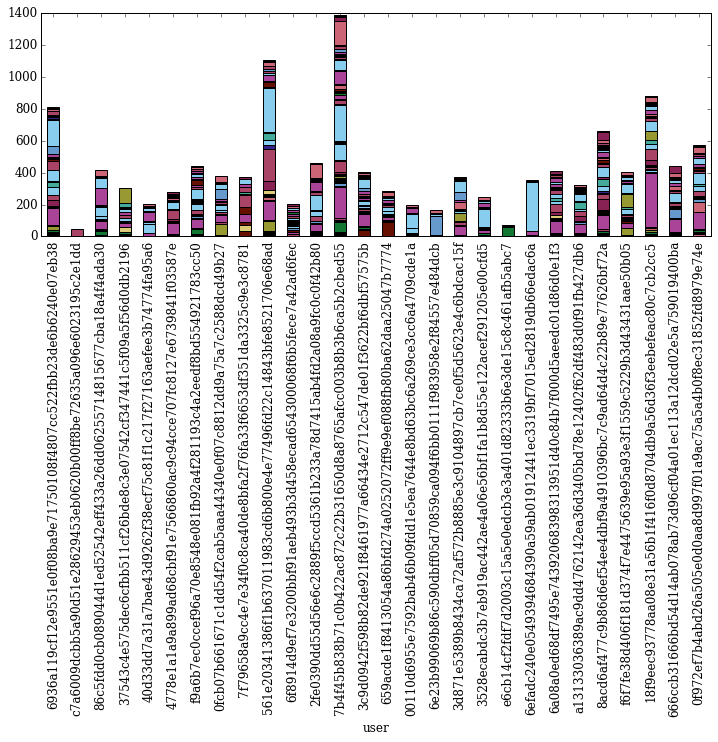

In [63]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(hspace=0.5,wspace=0.3)

ax1 = plt.subplot2grid((1,1), (0,0))
users_permonth.ix[alltop10_without_outliers].plot(kind='bar',ax=ax1, legend=False, stacked=True, color=mycolors12, title="")
# ax1.axes.get_xaxis().set_ticks([])
# ax1.set_xlabel("Top 10 users")
# ax1.set_ylabel("# acesses to Booters")
# ax1.xaxis.set_tick_params(labelsize=10)
# ax1.yaxis.set_tick_params(labelsize=10)

fig.show()
#fig.savefig('figs/booters_accessed_top10users.eps', bbox_inches='tight',format='eps', dpi=1200)
#plotly.offline.iplot_mpl(fig )

<div id="3"><h1><a href="#TOC">3. What happened in the last week?</a></h1></div>

In [64]:
# CODE:
from datetime import date, timedelta
lastweek = date.today() - timedelta(days=7)

df_lastweek=indexed_df[lastweek:].reset_index()

# booters_lastweek=len(df_lastweek[df_lastweek['recordtype']=='Q(Q)']['value'].value_counts())
users_lastweek=df_lastweek[df_lastweek['recordtype']=='Q(Q)']['user'].value_counts()
# users_lastweek_sorted=df_lastweek[df_lastweek['recordtype']=='Q(Q)']['user'].value_counts().index.tolist()

users_lastweek_min = pd.pivot_table(df_lastweek[df_lastweek['recordtype']=='Q(Q)'],\
                    index=pd.Grouper(key='timestamp',freq='D'), \
                    columns='user', \
                    values='unit', \
                    aggfunc=np.sum, \
                    fill_value=0)

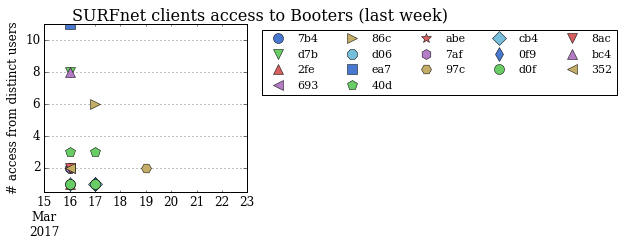

In [66]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot2grid((1,2), (0,0))
ax1 = users_lastweek_min.plot(ax=ax1, style=mymarkers, markersize=10, legend=False)

ax1.set_ylabel("# access from distinct users")
ax1.set_xlabel("")

ax1.set_ylim(0.5,11)
ax1.set_xlim(date.today() - timedelta(days=8),date.today())
            
ax1.legend(users_lastweek.index.str[:3],
           prop={'size':11},
           numpoints=1, ncol=5,
           bbox_to_anchor=(2.85, 1))

ax1.yaxis.grid()
fig.suptitle('SURFnet clients access to Booters (last week)', fontsize=16)

plt.show()
fig.suptitle('')
fig.savefig('figs/last_week.eps', bbox_inches='tight',format='eps', dpi=1200)

#plotly.offline.iplot_mpl(fig)

# Correlation with Vdos-s Booter 

In [67]:
len(df[(df['recordtype']=='Q(Q)') &(df['value']=='vdos-s.com.')]['user'].value_counts())

68